<a href="https://colab.research.google.com/github/edgi-govdata-archiving/EEW-SOEP/blob/main/SOE_GHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GHG
This notebook will be used to measure indicators for EDGI/EEW's "state of the environment" report ahead of Trump's second administration.

It will pull greenhouse gas emissions reported under EPA's Greenhouse Gas Reporting Program (GHGRP).

GHGRP only covers certain facilities - those who directly emit GHGs and those (e.g. oil refineries) who supply products (e.g. gasoline) that result in GHGs. GHGs from land use change is not included. Still, because it includes both direct emitters (e.g. coal-fired power plants) and suppliers (e.g. of the gas you burn in your car), the GHGRP is estimated to account for 85-90% of all US GHGs. Source: https://www.epa.gov/ghgreporting/ghgrp-and-us-inventory-greenhouse-gas-emissions-and-sinks



In [4]:
# GHGRP
# Access: https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip
# Data dictionary: https://www.epa.gov/rsei/rsei-data-dictionary-elements-data

# Get the data
import requests, zipfile, io
# Pull the zip file into this notebook
url = "https://www.epa.gov/system/files/other-files/2024-10/2023_data_summary_spreadsheets.zip"
r = requests.get(url, verify=False)
# Unzip the file
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("GHGRP_DATA")

c:\Users\Ashok\Documents\GitHub\EEW-SOEP\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.epa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [8]:
# Load GHGRP data into notebook
"""
GHGRP data is split between direct emitters and suppliers.
Within direct emitters, there are various categories: direct, onshore oil and gas,
pipelines, local distribution companies, etc.
"""
import pandas as pd
ghg_fac = pd.read_excel("./GHGRP_DATA/ghgp_data_by_year_2023.xlsx",
  skiprows = 1, # skip the first two rows, which are irrelevant
  header = 2, # the third row represents the header
  converters={'Primary NAICS Code':str}, # read the NAICS codes as strings
  sheet_name = ["Direct Point Emitters", "Onshore Oil & Gas Prod.", "Gathering & Boosting",
    "Transmission Pipelines", "LDC - Direct Emissions", "SF6 from Elec. Equip.", "Suppliers"])
ghg_fac

{'Direct Point Emitters':       Facility Id        FRS Id  \
 0         1004377  1.100438e+11   
 1         1010040  1.100712e+11   
 2         1010085  1.100555e+11   
 3         1001155  1.100709e+11   
 4         1012147  1.100701e+11   
 ...           ...           ...   
 8732      1001308  1.100125e+11   
 8733      1010592  1.100712e+11   
 8734      1000805  1.100213e+11   
 8735      1001464  1.100008e+11   
 8736      1011696  1.100640e+11   
 
                                           Facility Name          City State  \
 0                        121 REGIONAL DISPOSAL FACILITY       MELISSA    TX   
 1                                     15-18565/15-18662        Hazard    KY   
 2                                              15-19015        Hazard    KY   
 3     1500 South Tibbs LLC d/b/a Aurorium Indianapol...  Indianapolis    IN   
 4                      17Z Gas Plant - Chevron USA Inc.    McKittrick    CA   
 ...                                                 ...     

In [10]:
"""
The emissions data are presented in several different sections of EPA's spreadsheet,
so here we compile them all together. In addition, we have emissions data going back to
2011, so we need to separate that out as well.

Emissions are measured in metric tons of CO2 equivalent, or tCO2e
(see: https://www.theguardian.com/environment/2011/apr/27/co2e-global-warming-potential)

"""

# First, handle SUPPLIERS separately
# Treat NaNs as zeros (not reported, maybe not emitted)
# Skip "confidential" values :(
for year in [*range(2011,2023,1)]:
  ghg_fac["Suppliers"][year] = None # Create new field to store results
  # Add emissions from all supplier categories together
  ghg_fac["Suppliers"][year] = pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with Coal-based liquid fuel production"], errors='coerce').fillna(0) + \
    pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with Petroleum Products Produced"], errors='coerce').fillna(0) + \
    pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with Petroleum Products Imported"], errors='coerce').fillna(0) + \
    pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with Petroleum Products Exported"], errors='coerce').fillna(0) + \
    pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with Natural Gas Supply"], errors='coerce').fillna(0) + \
    pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with Natural Gas Liquids Supply"], errors='coerce').fillna(0) + \
    pd.to_numeric(ghg_fac["Suppliers"][str(year)+" "+"GHG Quantity Associated with CO2 Supply "], errors='coerce').fillna(0)

# Handle 2023 separately
ghg_supplier_2023 = pd.read_excel("./GHGRP_DATA/ghgp_data_2023.xlsx",
  skiprows = 1, # skip the first two rows, which are irrelevant
  header = 2, # the third row represents the header
  converters={'Primary NAICS Code':str}, # read the NAICS codes as strings
  sheet_name = ["Direct Point Emitters", "Onshore Oil & Gas Prod.", "Gathering & Boosting",
    "Transmission Pipelines", "LDC - Direct Emissions", "SF6 from Elec. Equip.", "Suppliers"])

year = 2023
  # Add emissions from all supplier categories together
ghg_supplier_2023["Suppliers"][year] = pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with Coal-based liquid fuel production"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with Petroleum Products Produced"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with Petroleum Products Imported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with Petroleum Products Exported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with Natural Gas Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with Natural Gas Liquids Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_supplier_2023["Suppliers"]["GHG Quantity Associated with CO2 Supply "], errors='coerce').fillna(0)
ghg_fac["Suppliers"] = pd.merge(ghg_fac["Suppliers"], ghg_supplier_2023["Suppliers"][["Facility Id", year]], on="Facility Id", how="left")
ghg_fac["Suppliers"]

,Facility Id,FRS Id,Facility Name,City,State,Zip Code,Address,County,Latitude,Longitude,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1012147,1.100701e+11,17Z Gas Plant - Chevron USA Inc.,McKittrick,CA,93251,22845 Highway 33,NaN,35.318187,-119.633884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,NaN
1,1013701,1.100709e+11,30-30 Gas Plant,Plains,TX,79355,2300 FM 1622,YOAKUM COUNTY,33.051880,-102.887920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0
2,1002574,1.100708e+11,3M COMPANY,ST PAUL,MN,55144,3M CENTER,RAMSEY COUNTY,45.032510,-93.094191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0
3,1006665,1.100139e+11,3M Chemical Operations' Cordova Facility,CORDOVA,IL,61242,22614 ROUTE 84 NORTH,ROCK ISLAND COUNTY,41.755000,-90.284167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0
4,1004836,1.100004e+11,3M Chemical Operations' Cottage Grove Facility,Cottage Grove,MN,55016,10746 Innovation Rd,WASHINGTON COUNTY,44.789444,-92.908333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,1014016,1.100710e+11,"Your Source Products, Inc.",Tampa,FL,33619,4907 Joanne Kearney Blvd,HILLSBOROUGH COUNTY,27.906120,-82.383070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0
1268,1011356,NaN,ZIA II GAS PLANT,Lea County,NM,88240,NaN,Lea,32.643022,-103.808867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0
1269,1000094,1.100712e+11,Zia Natural Gas Company,Ruidoso Downs,NM,88346,100 Short Drive,LINCOLN COUNTY,33.329790,-105.594910,...,168783.1,175609.7,168592.2,170228.6,181419.0,311069.4,147529.4,169807.7000,157210.8000,170133.4
1270,1004910,1.100712e+11,city of statesboro,Statesboro,GA,30459,50 East Main Street,BULLOCH COUNTY,32.448830,-81.781660,...,30446.0,30049.4,29261.8,28095.9,29027.6,55215.2,26300.2,29408.9000,31148.7000,28740.4


In [14]:
# DIRECT EMITTERS
import warnings
warnings.filterwarnings("ignore") # Ignore some warnings from pandas

# Note that some of these are only available from 2016
direct_emissions_field_names = {
    "Direct Point Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

# Create a new DataFrame to store emissions data compiled from direct emitters
fac_directemitters_data = pd.DataFrame([], columns=["Facility Id", "Facility Name"].extend([*range(2011,2024,1)]))

# Compile emissions data across direct emitters.
for key in direct_emissions_field_names.keys():
  dump = ghg_fac[key]
  for year in [*range(2011,2024,1)]:
    try:
      this_year = dump[["Facility Id", "Facility Name", str(year)+" "+direct_emissions_field_names[key]]] # Filter to relevant columns
      this_year[year] = pd.to_numeric(this_year[str(year)+" "+direct_emissions_field_names[key]]) # Get emissions
      fac_directemitters_data = pd.concat([fac_directemitters_data, this_year]) # Add to existing direct emitters
    except:
      pass

# Roll up duplicate facility IDs (facilities with e.g. both point emissions and onshore oil...)
fac_directemitters_data = fac_directemitters_data.groupby(by=["Facility Id", "Facility Name"])[[*range(2011,2024,1)]].sum().reset_index() #For presentation purposes, we'll add in the facility name

fac_directemitters_data

,Facility Id,Facility Name,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1000001,PSE Ferndale Generating Station,35878.164,14719.108,395314.784,333193.564,405725.952,354145.488,350890.100,302529.480,478279.876,509154.612,637259.640,464785.558,715257.160
1,1000002,Ardagh Glass Inc. (Dunkirk),109863.600,111294.548,103822.920,114959.652,114583.804,114530.004,115937.540,110511.712,118958.692,113519.804,116830.596,115616.900,116955.040
2,1000003,Ardagh Glass Inc. (Henderson),77199.184,74324.196,80535.232,81003.988,80976.036,74813.296,80219.128,79393.210,80097.188,81110.872,79993.496,79156.516,77625.440
3,1000004,Ardagh Glass Inc. (Lincoln),52494.612,60085.996,59600.496,57837.096,59954.736,54780.848,57894.492,55547.748,15613.656,0.000,0.000,0.000,0.000
4,1000005,Ardagh Glass Inc. (Madera),75969.472,82149.608,78249.768,74754.144,81133.624,79708.576,82451.324,83854.020,81665.820,79854.076,78060.732,76626.784,71574.356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10087,1014920,Formentera Operations - Permian Basin,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,25588.746
10088,1014921,Avista Landfill,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6485.500
10089,1015119,VMC Specialty Alloys LLC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,38314.756,38971.804
10090,1015127,Kronospan Simsboro LLC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,37678.504


Direct Point Emitters


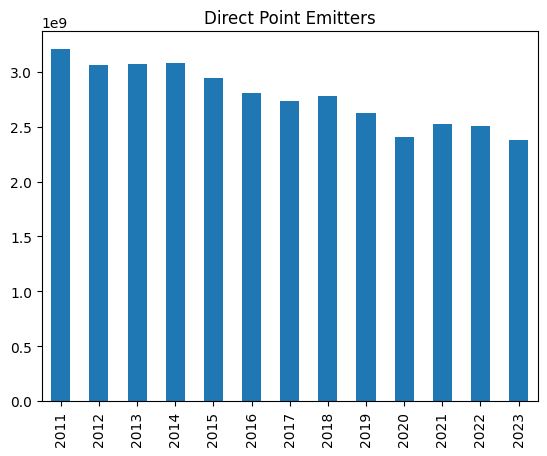

Onshore Oil & Gas Prod.


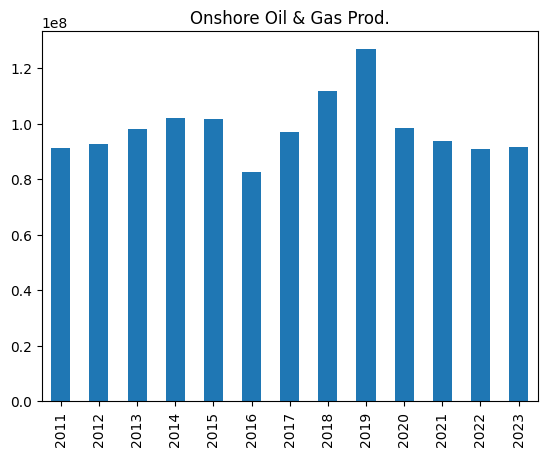

Gathering & Boosting
Transmission Pipelines
LDC - Direct Emissions


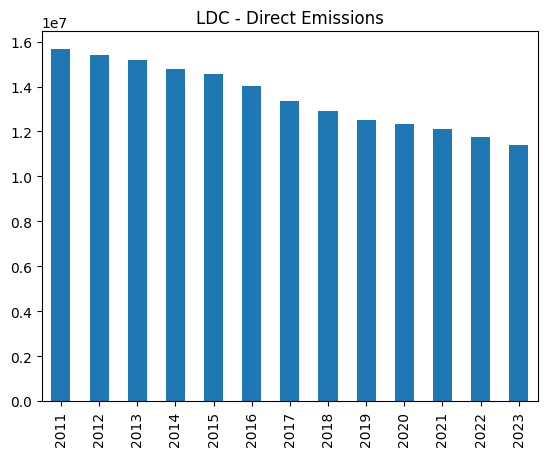

SF6 from Elec. Equip.


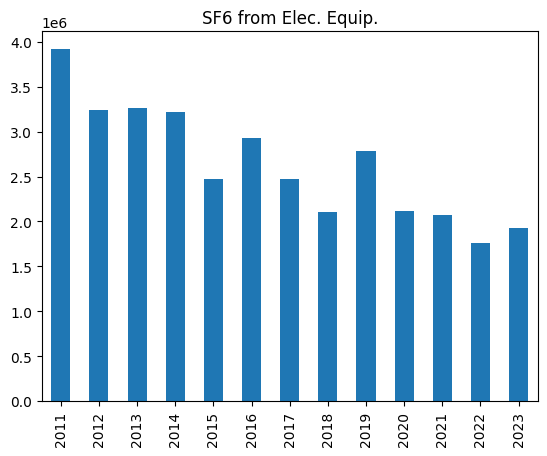

In [15]:
# Investigate direct emissions types trends
import matplotlib.pyplot as plt

%matplotlib inline

types = {}
for key in direct_emissions_field_names.keys():
  dump = ghg_fac[key]
  types[key] = dump[["Facility Id", "Facility Name"]] # Filter to relevant columns
  for year in [*range(2011,2024,1)]:
    try:
      types[key][year] = pd.to_numeric(dump[str(year)+" "+direct_emissions_field_names[key]]) # Get emissions
    except:
      pass
  #display(types[key])
  print(key)
  try:
    test = types[key][[*range(2011,2024,1)]].sum()
    test.plot(title=key, kind="bar")
    plt.show()
  except:
    pass


In [16]:
# Indicators to measure and visualize
# Total direct emissions, 2011-2022 (fac_directemitters_data)
# Total supplier emissions, 2011-2022 (fac_supplier_data)
print("Direct Emitters")
for year in [*range(2011,2024,1)]:
  print(year, fac_directemitters_data[year].sum())
print("Suppliers")
for year in [*range(2011,2024,1)]:
  print(year, ghg_fac["Suppliers"][year].sum())

Direct Emitters
2011 3318362058.7428155
2012 3169264089.920809
2013 3189593124.453332
2014 3204012593.867202
2015 3058101582.719764
2016 2906894591.106976
2017 2850072318.4755964
2018 2908760839.991402
2019 2773072537.8315105
2020 2519075979.41869
2021 2634100701.4754677
2022 2610772846.7603235
2023 2489094506.041667
Suppliers
2011 3744316426.0748444
2012 3912056225.544631
2013 4053434550.5436234
2014 4249260133.120437
2015 4324361957.2376585
2016 4410893685.810587
2017 4455627024.439388
2018 4669428456.295819
2019 4692064444.428015
2020 4217687319.2109704
2021 3804348894.586698
2022 5631038759.08736
2023 4650647214.990006


In [17]:
# Intensity - emissions per source

print("Direct Emitters")
for year in [*range(2011,2024,1)]:
  dump = fac_directemitters_data[fac_directemitters_data[year]>0]
  print(dump[year].sum()/dump.shape[0])

print("Suppliers")
for year in [*range(2011,2024,1)]:
  dump = ghg_fac["Suppliers"][ghg_fac["Suppliers"][year]>0]
  print(dump[year].sum()/dump.shape[0])

Direct Emitters
436684.04510367353
404862.55619836604
402777.26031737996
396241.97302339855
383124.8783475024
396737.3537746657
393765.17248902965
396450.9799633913
378679.8494922178
345694.52167129
363073.83893528156
361552.8107963334
347444.7942548391
Suppliers
5539111.124740041
5778536.244969913
5960935.21285827
6258115.070869569
6406462.158870605
6724327.985130316
6823318.5672884965
7011153.8382820105
6859743.339807039
6313903.172471512
5795364.500471721
8455013.151782824
7358619.011060136


In [ ]:
categories = [
  "GHG Quantity Associated with Petroleum Products Produced",
  "GHG Quantity Associated with Petroleum Products Imported",
  "GHG Quantity Associated with Petroleum Products Exported",
  "GHG Quantity Associated with Natural Gas Supply",
  "GHG Quantity Associated with Natural Gas Liquids Supply",
  "GHG Quantity Associated with CO2 Supply "
]
dfdf = pd.DataFrame(ghg_fac[0])
dfdf.to_csv("ghg_fac.csv")
for c in categories:
  print(c)
  cols = ghg_fac["Suppliers"].filter(like=c).columns
  # Assume "confidential" values = 0 !!!!!
  test = ghg_fac["Suppliers"][cols]
  # rename
  test = test.rename(dict(zip(test.columns, [*range(2023,2010,-1)])), axis=1)
  # Calculate
  test = test.replace("confidential", "0").astype(float).sum()
  #display(test)
  test = test.iloc[::-1]

  test.plot(title=c, kind="bar")
  plt.show()


ValueError: If using all scalar values, you must pass an index